# parPE Lucarelli example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sbml_file = 'lucarelli_12.xml'
model_name = 'lucarelli_12'
model_output_dir = 'lucarelli_12'

In [3]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['TGFb', 'Rec', 'TGFb_pRec', 'S2', 'S3', 'S4', 'S2_S4_S4', 'ppS2_ppS2_ppS2', 'ppS3_ppS3_ppS3', 'S4_S4_S4', 'pS2', 'pS3', 'ppS2', 'ppS3', 'ppS2_ppS2_S4', 'ppS2_ppS2_ppS3', 'ppS2_ppS3_ppS3', 'ppS3_ppS3_S4', 'ppS2_ppS3_S4', 'ppS3_S4_S4', 'ppS2_S4_S4', 'geneA', 'geneB', 'geneC', 'geneD', 'geneE', 'geneF', 'geneG', 'geneH', 'geneI', 'geneJ', 'geneK', 'geneL']
Parameters:  ['Rec_act', 'S_dephos', 'S_dephosphos', 'S_phos', 'geneA_act1', 'geneA_act2', 'geneA_act3', 'geneA_inh1', 'geneA_inh2', 'geneA_inh3', 'geneA_turn', 'geneB_act1', 'geneB_act2', 'geneB_act3', 'geneB_inh1', 'geneB_inh2', 'geneB_inh3', 'geneB_turn', 'geneC_act1', 'geneC_act2', 'geneC_act3', 'geneC_inh1', 'geneC_inh2', 'geneC_inh3', 'geneC_turn', 'geneD_act1', 'geneD_act2', 'geneD_act3', 'geneD_inh1', 'geneD_inh2', 'geneD_inh3', 'geneD_turn', 'geneE_act1', 'geneE_act2', 'geneE_act3', 'geneE_inh1', 'geneE_inh2', 'geneE_inh3', 'geneE_turn', 'geneF_act1', 'geneF_act2', 'geneF_act3', 'geneF_inh1', 'geneF_inh2', 'geneF_inh

## Generate model code

In [4]:
# remove time from the list of names
observables_list = ['observable_Ski', 'observable_Skil', 'observable_Dnmt3a', 'observable_Sox4', 'observable_Jun', 'observable_Smad7', 'observable_Klf10', 'observable_Bmp4', 'observable_Cxcl15', 'observable_Dusp5', 'observable_Tgfa', 'observable_Pdk4'] #
fixed_parameters = ['init_TGFb', 'init_S2', 'init_S3', 'init_S4']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(
                  sbmlImporter.sbml, # the libsbml model object
                  filter=lambda variableId: variableId in observables_list)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters)


In [5]:
createModule(sbml_file, model_name, model_output_dir)

## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(22,33):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[5.98343089e-03 2.86397320e-01 4.89949146e-02 3.79720143e-01
 1.41389661e-02 7.97280888e-04 0.00000000e+00 0.00000000e+00
 4.62523982e-02 2.63810590e-02 4.55788978e-03 4.61699171e-01
 7.38527752e-02 3.04255474e-02 0.00000000e+00 7.47200750e-01
 4.07329851e-01 1.12459405e-02 7.14636599e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.84415822e-02 3.53796933e-02
 3.78630405e-03 1.11673720e-02 2.68942133e-04 0.00000000e+00
 0.00000000e+00 8.68803386e-02 1.01419106e-01 8.02160834e-04
 0.00000000e+00 1.03661056e+00 6.10224670e+00 8.20035989e+00
 1.43925487e+00 9.67035015e+00 1.24380539e-01 9.98299920e+02
 1.35655044e-01 2.06442242e+01 3.63157062e+00 0.00000000e+00
 0.00000000e+00 3.66724104e+01 6.26768522e+02 5.59534538e+01
 0.00000000e+00 0.00000000e+00 1.75854489e-02 8.15621976e-04
 2.95971428e+02 0.00000000e+00 8.99866383e+01 9.99921986e+02
 9.99998961e+02 1.90317907e+01 2.18356691e+02 9.92827361e-01
 9.30152789e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.20763519e+02 9.999816

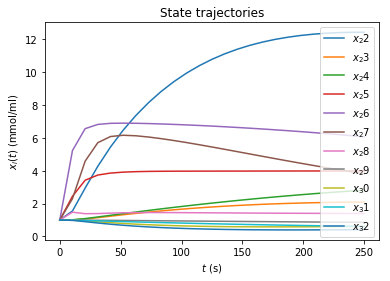

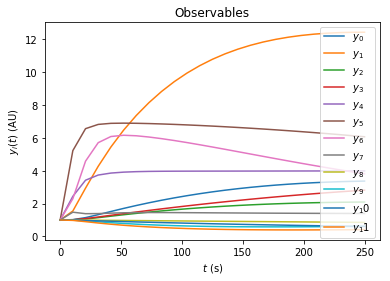

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import lucarelli_12 as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 250, 25))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
from pandas import DataFrame

def createConditionDataframe(indices, conditions, parameters):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index=indices)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf

def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    measurement = np.random.normal(loc=rdata['y'], scale=sigmay)
    measurement = np.random.normal(
        loc=rdata['y'], 
        scale=sigmay[0][0])
    # print(measurement)

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    # return generated noisy measurents
    rdata['y'] = measurement
    return rdata

expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
timepoints = np.linspace(0, 100, 5)

model = modelModule.getModel()
true_parameters = np.array(model.getParameters())

# setup model & solver
model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(timepoints))
model.setParameters(amici.DoubleVector(true_parameters))

solver = model.getSolver()
solver.setMaxSteps(10000)

# generate conditon-vectors
sigma = 0.5
mu = 1.5
nConditions = 10
init_TGFb = np.linspace(0,1,11)
init_conditions = [10.0**(mu + sigma * np.random.randn(4))]
init_conditions[0][0] = init_TGFb[np.random.randint(0,11)]
for i in range(1,nConditions):
    init_conditions.append(np.array(10.0**(mu + sigma * np.random.randn(4))))
    init_conditions[i][0] = init_TGFb[np.random.randint(0,11)]
    
indices = fixed_parameters
conditionDf = createConditionDataframe(indices, init_conditions, true_parameters)
    
df = pd.DataFrame(data={
    'observable': [],
    'condition': [],
    'conditionRef': [],
    'time': [],
    'measurement': [],
})

for icondition, condition in enumerate(init_conditions):      
    
    simulationParameters = true_parameters
    sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
    
    # simulate condition
    rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)

    expectedLlh += rdata['llh']
    
    conditionName = 'condition-%d' % icondition
    
    # Append data
    for iy, observableName in enumerate(observables.keys()):
        scalingParameter = [''] 
        sigma = sigmay[:, iy]
        
        df = df.append(pd.DataFrame(
        {'observable'      : [observableName] * model.nt(),
         'condition'       : [conditionName]  * model.nt(),
         'conditionRef'    : ['']  * model.nt(),
         'scalingParameter': scalingParameter * model.nt(),
         'time'            : np.array(model.getTimepoints()),
         'measurement'     : rdata['y'][:, iy],
         'sigma'           : sigma
         }), ignore_index=True)
print('Expected llh: ', expectedLlh)

Expected llh:  534.1215236774566


In [9]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3,condition-4,condition-5,condition-6,condition-7,condition-8,condition-9
init_TGFb,init_TGFb,0.100000,0.200000,0.400000,0.800000,0.800000,0.100000,0.100000,0.800000,0.100000,0.500000
init_S2,init_S2,61.695176,41.992923,23.074720,44.907850,13.354853,405.864982,43.578551,24.287830,84.784401,29.798505
init_S3,init_S3,31.201709,67.033439,69.558265,36.468648,10.105092,9.910768,186.894222,24.986030,1312.069615,224.886220
init_S4,init_S4,12.796036,24.064931,12.846904,70.928341,33.185558,14.518162,18.602187,8.308639,116.715126,18.019798


In [10]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,,0.887312,observable_Ski,,0.1,0.0
1,condition-0,,1.232128,observable_Ski,,0.1,25.0
2,condition-0,,1.684739,observable_Ski,,0.1,50.0
3,condition-0,,1.894554,observable_Ski,,0.1,75.0
4,condition-0,,2.495547,observable_Ski,,0.1,100.0
5,condition-0,,0.964221,observable_Skil,,0.1,0.0
6,condition-0,,3.420663,observable_Skil,,0.1,25.0
7,condition-0,,6.271809,observable_Skil,,0.1,50.0
8,condition-0,,8.211042,observable_Skil,,0.1,75.0
9,condition-0,,9.622630,observable_Skil,,0.1,100.0


In [12]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

! /bin/bash -c "if [[ -f example_data.h5 ]]; then cp example_data.h5 example_data.h5.bak; fi"
# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert 0 == out.returncode, "Returned " + str(out.returncode)


Measurements shape (600, 7)
Changing t = Inf to t = 1e8.
Num conditions:  10
Num timepoints:  5 [0.0, 25.0, 50.0, 75.0, 100.0]
Fixed parameters orginal:  (4, 10)
Fixed parameters usable:  (4, 10)
Generate parameter list...
Number of simulation parameters: 114
Number of optimization parameters: 114
Generating fixed parameters matrix...
Number of fixed parameters: 4
Generating measurement matrix...
Number of observables: 12
Handling scaling parameters...
Copying default AMICI options...
Writing default optimization options...



In [20]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            if true_parameters[i] < 1e-10:
                true_parameters_scaled[i] = -10.0
            else:
                true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    print(true_parameters_scaled)
    
    for i in range(10):
        parameters = true_parameters_scaled
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters
        
hdf5FileMinibatch = 'example_data_minibatch.h5'
!cp {hdf5File} {hdf5FileMinibatch}

In [21]:
# enable derivate checker
#!../../../misc/optimizationOptions.py {hdf5File} -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py {hdf5File} -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py {hdf5File} -s numStarts 1
!../../../misc/optimizationOptions.py {hdf5File} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {hdf5File}

                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

In [35]:
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s numStarts 1
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s optimizer 10 # minibatch
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/maxEpochs 10
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/batchSize 1
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!../../../misc/optimizationOptions.py {hdf5FileMinibatch}

                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            0
                               optimizer           10
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Rebuild executables

In [23]:
!pwd
!(cd ../../../build && exec make -j12)

/home/dweindl/src/parPE/amici/examples/lucarelli
[  5%] Built target parpecommon
[ 23%] Built target model_steadystate_scaled
-- Found Git: /usr/bin/git (found version "2.17.1") 
[ 41%] Built target lucarelli_12
-- Building version parPE-v0.1.8-37-ge4a1b-dirty
[ 43%] Built target parpeloadbalancer
[ 44%] Built target simulate_model_steadystate_scaled
[ 47%] Built target unittests_common
[ 47%] Built target get_version
[ 48%] Building CXX object optimization/src/CMakeFiles/parpeoptimization.dir/optimizationResultWriter.cpp.o
[ 49%] Built target simulate_lucarelli_12
[ 50%] Built target example_loadbalancer
[ 52%] Built target unittests_loadbalancer
[ 52%] Linking CXX static library libparpeoptimization-dbg.a
[ 57%] Built target parpeoptimization
Scanning dependencies of target parpeamici
[ 58%] Linking CXX executable example_steadystate
[ 59%] Linking CXX executable unittests_optimization_ceres
[ 60%] Linking CXX executable unittests_optimization
[ 61%] Linking CXX executable unittests_

## Gradient check

In [29]:
for i in range(1):
    !PARPE_NO_DEBUG=1 PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/lucarelli/estimateLucarelli -t gradient_check -o deletemegc/ example_data.h5


[2018-09-01 00:16:10] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-09-01 00:16:10] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-09-01 00:16:10] [DBG] [1/dweindl] Seeding RNG with 1535753770
[2018-09-01 00:16:10] [DBG] [2/dweindl] Seeding RNG with 1535753770
[2018-09-01 00:16:10] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-09-01 00:16:10] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-09-01 00:16:10] [DBG] [3/dweindl] Seeding RNG with 1535753770
[2018-09-01 00:16:10] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-09-01 00:16:10] [DBG] [0/dweindl] Seeding RNG with 1535753770
[2018-09-01 00:16:10] [INF] [0/dweindl] Reading options and data from 'example_data.h5'.
[2018-09-01 00:16:10] [DBG] [1/dweindl] Message received after waiting 0.005393s.
[2018-09-01 00:16:10] [DBG] [3/dweindl] Message received after waiting 0.005503s.
[2018-09-01 00:16:10] [DBG] [2/dweindl] Message received after waiting 0.005302s.
-----------------------------------------------

## IpOpt optimization

In [30]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/lucarelli/estimateLucarelli -o deleteme/ example_data.h5


[2018-09-01 00:17:43] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-09-01 00:17:43] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-09-01 00:17:43] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-09-01 00:17:43] [DBG] [2/dweindl] Seeding RNG with 1535753863
[2018-09-01 00:17:43] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-09-01 00:17:43] [DBG] [3/dweindl] Seeding RNG with 1535753863
[2018-09-01 00:17:43] [DBG] [0/dweindl] Seeding RNG with 1535753863
[2018-09-01 00:17:43] [INF] [0/dweindl] Reading options and data from 'example_data.h5'.
[2018-09-01 00:17:43] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-09-01 00:17:43] [DBG] [1/dweindl] Seeding RNG with 1535753863
[2018-09-01 00:17:43] [DBG] [0/dweindl] Starting runParallelMultiStartOptimization with 1 starts
[2018-09-01 00:17:43] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2018-09-01 00:17:43] [DBG] [0/dweindl] Spawning thread for local optimization #0 (0)


[2018-09-01 00:18:49] [DBG] [2/dweindl] [c1] Result for 22: -3.09052e+12 (0) (0.0275s-)
[2018-09-01 00:18:49] [DBG] [2/dweindl] Message received after waiting 0.000165s.
[2018-09-01 00:18:49] [DBG] [3/dweindl] [c2] Result for 23: -3.09052e+12 (0) (0.0327s-)
[2018-09-01 00:18:49] [DBG] [3/dweindl] Message received after waiting 0.000054s.
[2018-09-01 00:18:49] [DBG] [2/dweindl] [c3] Result for 24: -3.09052e+12 (0) (0.0289s-)
[2018-09-01 00:18:49] [DBG] [2/dweindl] Message received after waiting 0.000620s.
[2018-09-01 00:18:49] [DBG] [1/dweindl] [c0] Result for 21: -3.09052e+12 (0) (0.0588s-)
[2018-09-01 00:18:49] [DBG] [3/dweindl] [c4] Result for 25: -3.09051e+12 (0) (0.0400s-)
[2018-09-01 00:18:49] [DBG] [1/dweindl] Message received after waiting 0.014748s.
[2018-09-01 00:18:49] [DBG] [3/dweindl] Message received after waiting 0.000080s.
[2018-09-01 00:18:49] [DBG] [2/dweindl] [c5] Result for 26: -3.09051e+12 (0) (0.0316s-)
[2018-09-01 00:18:49] [DBG] [2/dweindl] Message received after

[2018-09-01 00:18:50] [DBG] [2/dweindl] [c4] Result for 75: -26011 (0) (0.0116s-)
[2018-09-01 00:18:50] [DBG] [3/dweindl] [c5] Result for 76: -25750.8 (0) (0.0098s-)
[2018-09-01 00:18:50] [DBG] [3/dweindl] Message received after waiting 0.000073s.
[2018-09-01 00:18:50] [DBG] [2/dweindl] Message received after waiting 0.000184s.
[2018-09-01 00:18:50] [DBG] [1/dweindl] [c3] Result for 74: -26066.4 (0) (0.0158s-)
[2018-09-01 00:18:50] [DBG] [1/dweindl] Message received after waiting 0.000064s.
[2018-09-01 00:18:50] [DBG] [2/dweindl] [c7] Result for 78: -25845.5 (0) (0.0079s-)
[2018-09-01 00:18:50] [DBG] [2/dweindl] Message received after waiting 0.000122s.
[2018-09-01 00:18:50] [DBG] [3/dweindl] [c6] Result for 77: -25714.1 (0) (0.0123s-)
[2018-09-01 00:18:50] [DBG] [2/dweindl] [c9] Result for 80: -25952.9 (0) (0.0077s-)
[2018-09-01 00:18:50] [DBG] [1/dweindl] [c8] Result for 79: -25954.4 (0) (0.0137s-)
[2018-09-01 00:18:50] [DBG] [1/dweindl] Message received after waiting 0.000979s.
[201

array([[55492.64368885, 31180.50085507]])

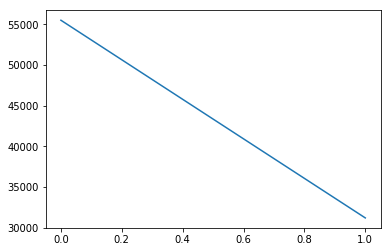

In [33]:
filename = 'deleteme/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

## Minibatch optimization

In [36]:
!mpiexec -np 4 ../../../build/amici/examples/lucarelli/estimateLucarelli -o deleteme-minibatch/ {hdf5FileMinibatch}


[2018-09-01 00:21:29] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-09-01 00:21:29] [DBG] [1/dweindl] Seeding RNG with 1535754089
[2018-09-01 00:21:29] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-09-01 00:21:29] [DBG] [3/dweindl] Seeding RNG with 1535754089
[2018-09-01 00:21:29] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-09-01 00:21:29] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-09-01 00:21:29] [DBG] [0/dweindl] Seeding RNG with 1535754089
[2018-09-01 00:21:29] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-09-01 00:21:29] [DBG] [2/dweindl] Seeding RNG with 1535754089
[2018-09-01 00:21:29] [INF] [0/dweindl] Reading options and data from 'example_data_minibatch.h5'.
[2018-09-01 00:21:29] [DBG] [0/dweindl] Starting runParallelMultiStartOptimization with 1 starts
[2018-09-01 00:21:29] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2018-09-01 00:21:29] [DBG] [0/dweindl] Spawning thread for local optimizati

[2018-09-01 00:21:37] [WRN] [0/dweindl] Thread ms #0 finished unsuccessfully... trying new starting point
[2018-09-01 00:21:37] [INF] [0/dweindl] Reading random initial theta 1 from /optimizationOptions/randomStarts
[2018-09-01 00:21:37] [DBG] [0/dweindl] Spawning thread for local optimization #1 (0)
[2018-09-01 00:21:37] [DBG] [0/dweindl] Set optimization option batchSize to 1.
[2018-09-01 00:21:37] [DBG] [0/dweindl] Set optimization option maxEpochs to 10.
[2018-09-01 00:21:37] [DBG] [0/dweindl] Set optimization option parameterUpdater to Vanilla.
[2018-09-01 00:21:37] [DBG] [1/dweindl] Message received after waiting 0.340248s.
[2018-09-01 00:21:45] [DBG] [1/dweindl] [o1e0b0c2] Result for 3: 52.8912 (0) (8.0260s+)
[2018-09-01 00:21:45] [DBG] [0/dweindl] [o1e0b0] : p: [ -2.22305 -0.543031 -1.30985 -0.420536 -1.84958 -3.09839 -10 -10 -1.33487 -1.57871 -2.34124 -0.335641 -1.13163 -1.51676 -10 -0.126563 -0.390054 -1.949 -2.14591 -10 -10 -10 -1.7342 -1.45125 -2.42178 -1.95205 -3.57034 -10

## Compare results

In [ ]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [ ]:
compareResults('deleteme-minibatch/_rank-0001.h5', -expectedLlh)

In [ ]:
!pwd

In [ ]:
!rm sim.h5
!../../../build/amici/examples/lucarelli/simulateLucarelli deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

In [ ]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

In [ ]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

In [ ]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)